# **Import and install relevant libraries**

In [ ]:
#install Deep CTR
!pip install deepctr[cpu]

In [ ]:
!pip install turicreate

     |████████████████████████████████| 91.8MB 47kB/s 
     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 327kB 57.3MB/s 
     |████████████████████████████████| 3.4MB 48.0MB/s 
     |████████████████████████████████| 450kB 51.3MB/s 
     |████████████████████████████████| 3.8MB 52.1MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=b96f4a5b14a2bd43b80f6f162ca9862c9de0b9d5a62f1def733d43df2c8765b7
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bc2f56df609718c97552b23347ea6a7db88162cb12edac29e911b6c57d81cf78
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
 

In [ ]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import random
import matplotlib.pyplot as plt # data visualization library
import operator

import turicreate
from sklearn.metrics import mean_absolute_error

import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape,  Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse

Connecting to drive


In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data

# **Question 1**

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
RATING_DATA_FILE = MOVIELENS_DIR+'u.item'

In [ ]:
m_cols = ['movie_id','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data= pd.read_csv(RATING_DATA_FILE,delimiter='|',names=m_cols,encoding='latin-1')
data.shape

(1682, 24)

In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
user_rating = pd.read_csv(MOVIELENS_DIR + 'u1.base',delimiter='\t', names=r_cols)
user_rating.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
average_movie_ratings = user_rating.groupby('movie_id')[['rating']].mean().round(1)
average_movie_ratings.head()

,rating
movie_id,
1,3.9
2,3.2
3,3.0
4,3.5
5,3.3


### 1.a finding the highest ranked movies

In [ ]:
movie_data_ratings_data=data.merge(average_movie_ratings,on = 'movie_id',how = 'inner')
movie_data_ratings_data.head(3)

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.9
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.2
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0


In [ ]:
rating_movie_count = average_movie_ratings.groupby('rating').size().reset_index(name='count')
rating_movie_count[rating_movie_count['rating'] == 3]

,rating,count
18,3.0,146


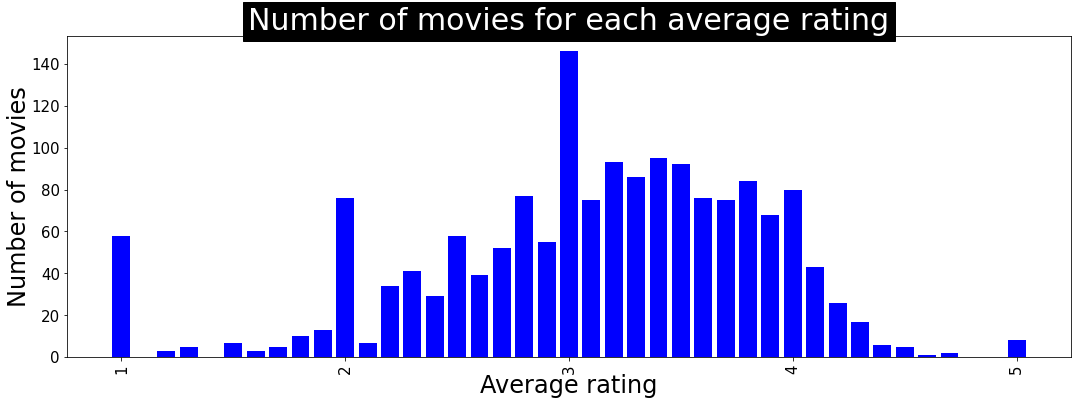

In [ ]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = rating_movie_count['count']
x_axis = rating_movie_count['rating']
plt.xticks(np.arange(min(x_axis), max(x_axis) + 1, 1), rotation=90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Number of movies", fontsize = 24, labelpad = 0)
plt.xlabel('Average rating', fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b', width=0.08)
plt.title("Number of movies for each average rating",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
sorted_ratings = movie_data_ratings_data.sort_values(by=['rating'], ascending=False)[['movie_id', 'movie title', 'rating']]
sorted_ratings.head(3)

,movie_id,movie title,rating
1620,1653,Entertaining Angels: The Dorothy Day Story (1996),5.0
1115,1122,They Made Me a Criminal (1939),5.0
1566,1599,Someone Else's America (1995),5.0


### 1.b.1 finding the highest ranked movies by female

In [ ]:
user_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])
user_data.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
female_user_data = user_data[user_data['gender'] == 'F']
female_user_data.head()

,user_id,age,gender,occupation,zip code
1,2,53,F,other,94043
4,5,33,F,other,15213
10,11,39,F,other,30329
11,12,28,F,other,06405
14,15,49,F,educator,97301


In [ ]:
female_user_rating = user_rating.merge(female_user_data['user_id'],on = 'user_id',how = 'inner')
female_user_rating.head()

,user_id,movie_id,rating,timestamp
0,2,1,4,888550871
1,2,10,2,888551853
2,2,14,4,888551853
3,2,25,4,888551648
4,2,100,5,888552084


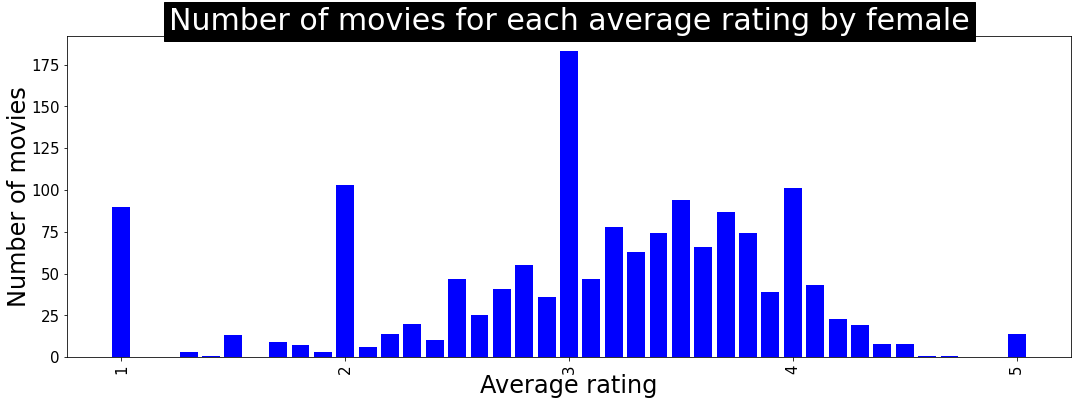

In [ ]:
female_average_movie_ratings = female_user_rating.groupby('movie_id')[['rating']].mean().round(1)

female_movie_data_ratings_data=data.merge(female_average_movie_ratings,on = 'movie_id',how = 'inner')

female_rating_movie_count = female_movie_data_ratings_data.groupby('rating').size().reset_index(name='count')

fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = female_rating_movie_count['count']
x_axis = female_rating_movie_count['rating']
plt.xticks(np.arange(min(x_axis), max(x_axis) + 1, 1), rotation=90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Number of movies", fontsize = 24, labelpad = 0)
plt.xlabel('Average rating', fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b', width=0.08)
plt.title("Number of movies for each average rating by female",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
female_sorted_ratings = female_movie_data_ratings_data.sort_values(by=['rating'], ascending=False)[['movie_id', 'movie title', 'rating']]
female_sorted_ratings.head(3)

,movie_id,movie title,rating
1286,1368,Mina Tannenbaum (1994),5.0
1364,1472,"Visitors, The (Visiteurs, Les) (1993)",5.0
1155,1189,Prefontaine (1997),5.0


### 1.b.2 finding the highest ranked movies by male

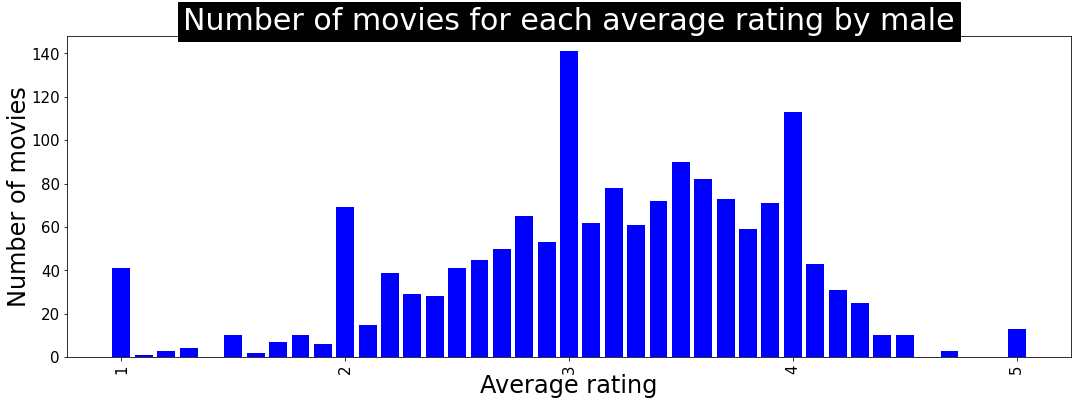

In [ ]:
male_user_data = user_data[user_data['gender'] == 'M']
male_user_rating = user_rating.merge(male_user_data['user_id'],on = 'user_id',how = 'inner')
male_average_movie_ratings = male_user_rating.groupby('movie_id')[['rating']].mean().round(1)

male_movie_data_ratings_data=data.merge(male_average_movie_ratings,on = 'movie_id',how = 'inner')

male_rating_movie_count = male_movie_data_ratings_data.groupby('rating').size().reset_index(name='count')

fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = male_rating_movie_count['count']
x_axis = male_rating_movie_count['rating']
plt.xticks(np.arange(min(x_axis), max(x_axis) + 1, 1), rotation=90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Number of movies", fontsize = 24, labelpad = 0)
plt.xlabel('Average rating', fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b', width=0.08)
plt.title("Number of movies for each average rating by male",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
male_sorted_ratings = male_movie_data_ratings_data.sort_values(by=['rating'], ascending=False)[['movie_id', 'movie title', 'rating']]
male_sorted_ratings.head(3)

,movie_id,movie title,rating
1156,1175,Hugo Pool (1997),5.0
1539,1656,Little City (1998),5.0
1105,1122,They Made Me a Criminal (1939),5.0


In [ ]:
merged_ratings = male_average_movie_ratings.merge(female_average_movie_ratings, on='movie_id', how='inner', suffixes=('_male', '_female'))
merged_ratings['rating_diff'] = np.abs(merged_ratings['rating_male'] - merged_ratings['rating_female'])
merged_ratings_with_movies = data.merge(merged_ratings[['rating_diff']], on='movie_id', how='inner').sort_values(by='rating_diff', ascending=False)
merged_ratings_with_movies[['movie_id', 'movie title', 'rating_diff']].head(3)

,movie_id,movie title,rating_diff
1131,1175,Hugo Pool (1997),4.0
830,851,Two or Three Things I Know About Her (1966),3.7
631,641,Paths of Glory (1957),3.5


### 1.c.1  finding the distribution of movies by genre

In [ ]:
genres = ['unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

In [ ]:
high_rated= movie_data_ratings_data['rating']>4.0
highR=movie_data_ratings_data[high_rated]
genres_count = {}


In [ ]:
for genre in genres:
    count = 0
    genre_movies = highR[genre] == 1
    genres_count[genre] = highR[genre_movies].shape[0]
print(genres_count)

{'unknown': 0, 'Action': 12, 'Adventure': 9, 'Animation': 4, 'Childrens': 1, 'Comedy': 16, 'Crime': 9, 'Documentary': 7, 'Drama': 56, 'Fantasy': 1, 'Film-Noir': 9, 'Horror': 1, 'Musical': 0, 'Mystery': 11, 'Romance': 14, 'Sci-Fi': 5, 'Thriller': 22, 'War': 19, 'Western': 2}


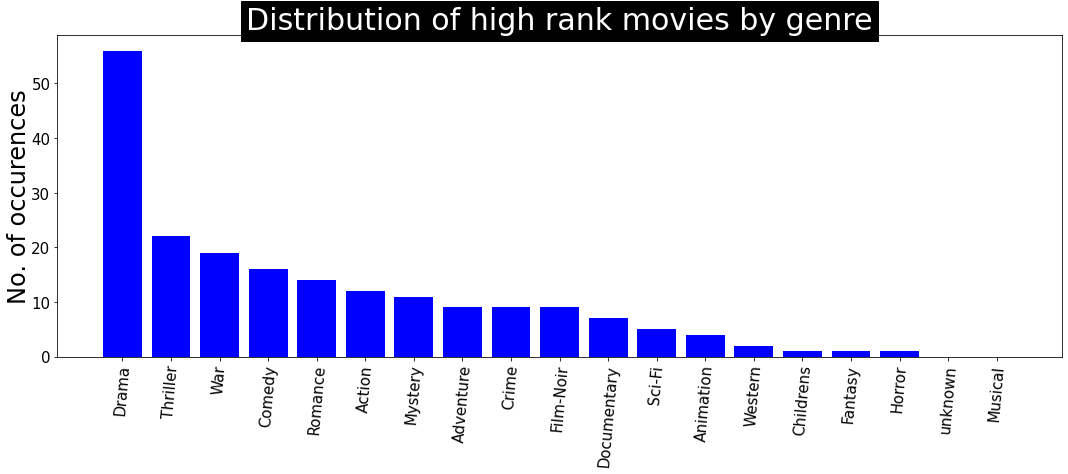

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of high rank movies by genre",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
low_rated= movie_data_ratings_data['rating']<2.0
lowR=movie_data_ratings_data[low_rated]
genres_count = {}
for genre in genres:
    count = 0
    genre_movies = lowR[genre] == 1
    genres_count[genre] = lowR[genre_movies].shape[0]


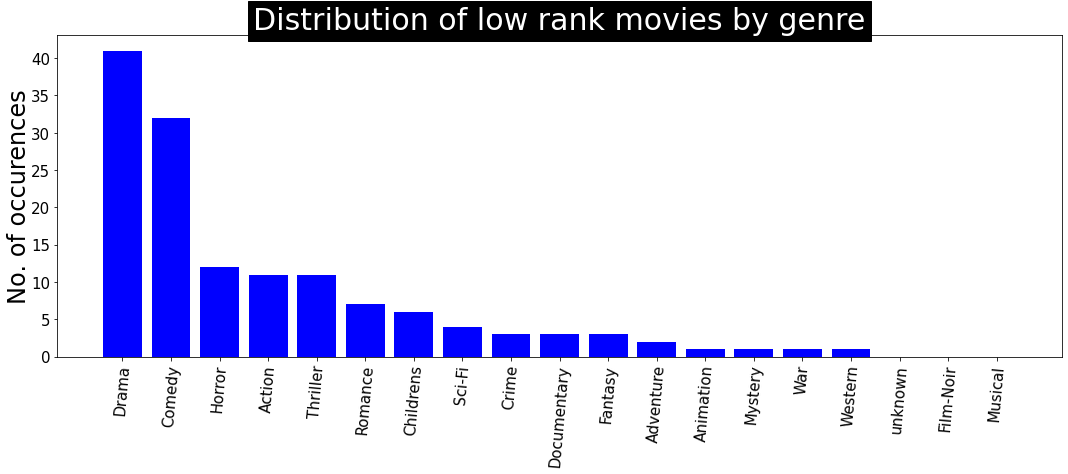

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of low rank movies by genre",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

### 1.c.2 Finding the distribution of movies by genre by male

In [ ]:
lowR=male_movie_data_ratings_data['rating']<2
male_low_rating=lowR=male_movie_data_ratings_data[lowR]
genres_count = {}
for genre in genres:
    count = 0
    genre_movies = male_low_rating[genre] == 1
    genres_count[genre] = male_low_rating[genre_movies].shape[0]
print(genres_count)


{'unknown': 0, 'Action': 9, 'Adventure': 5, 'Animation': 0, 'Childrens': 10, 'Comedy': 30, 'Crime': 3, 'Documentary': 2, 'Drama': 29, 'Fantasy': 2, 'Film-Noir': 0, 'Horror': 11, 'Musical': 1, 'Mystery': 0, 'Romance': 5, 'Sci-Fi': 4, 'Thriller': 8, 'War': 0, 'Western': 1}


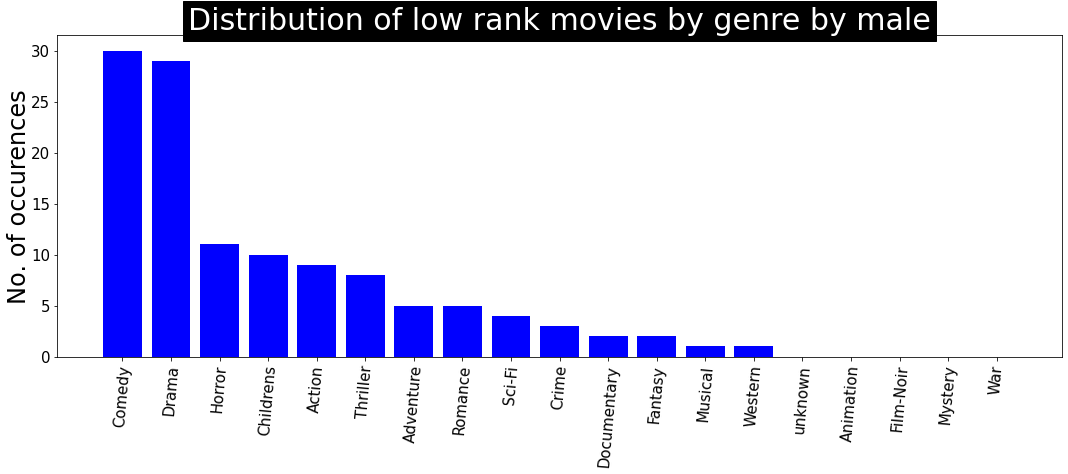

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of low rank movies by genre by male",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
highR=male_movie_data_ratings_data['rating']>4
male_high_rating=lowR=male_movie_data_ratings_data[highR]
genres_count = {}
for genre in genres:
    count = 0
    genre_movies = male_high_rating[genre] == 1
    genres_count[genre] = male_high_rating[genre_movies].shape[0]
print(genres_count)

{'unknown': 0, 'Action': 11, 'Adventure': 10, 'Animation': 4, 'Childrens': 3, 'Comedy': 24, 'Crime': 14, 'Documentary': 6, 'Drama': 69, 'Fantasy': 1, 'Film-Noir': 12, 'Horror': 3, 'Musical': 0, 'Mystery': 13, 'Romance': 16, 'Sci-Fi': 7, 'Thriller': 27, 'War': 18, 'Western': 2}


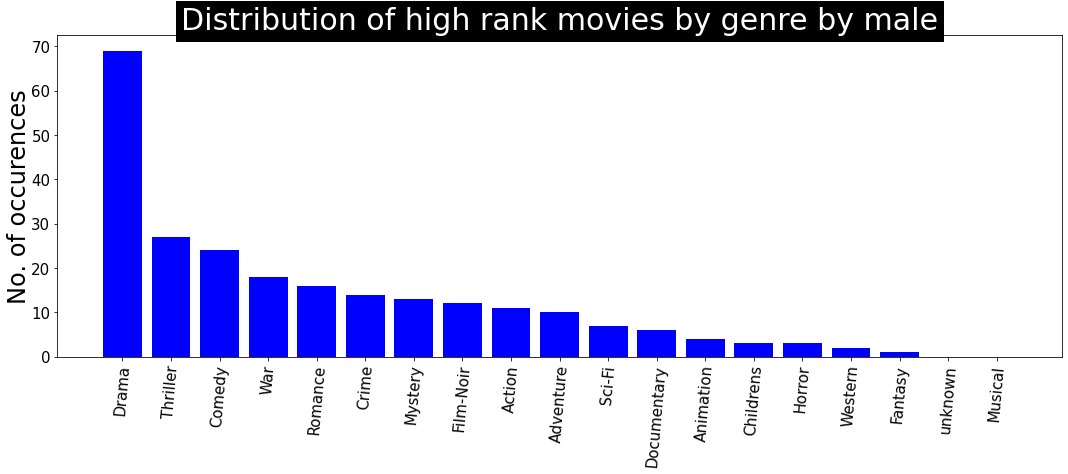

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of high rank movies by genre by male",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

### 1.c.3 Finding the distribution of movies by genre by female

In [ ]:
highR=female_movie_data_ratings_data['rating']>4
female_high_rating=lowR=female_movie_data_ratings_data[highR]
genres_count = {}
for genre in genres:
    count = 0
    genre_movies = female_high_rating[genre] == 1
    genres_count[genre] = female_high_rating[genre_movies].shape[0]
print(genres_count)

{'unknown': 0, 'Action': 14, 'Adventure': 5, 'Animation': 5, 'Childrens': 3, 'Comedy': 25, 'Crime': 3, 'Documentary': 4, 'Drama': 63, 'Fantasy': 0, 'Film-Noir': 2, 'Horror': 1, 'Musical': 5, 'Mystery': 7, 'Romance': 27, 'Sci-Fi': 4, 'Thriller': 19, 'War': 13, 'Western': 0}


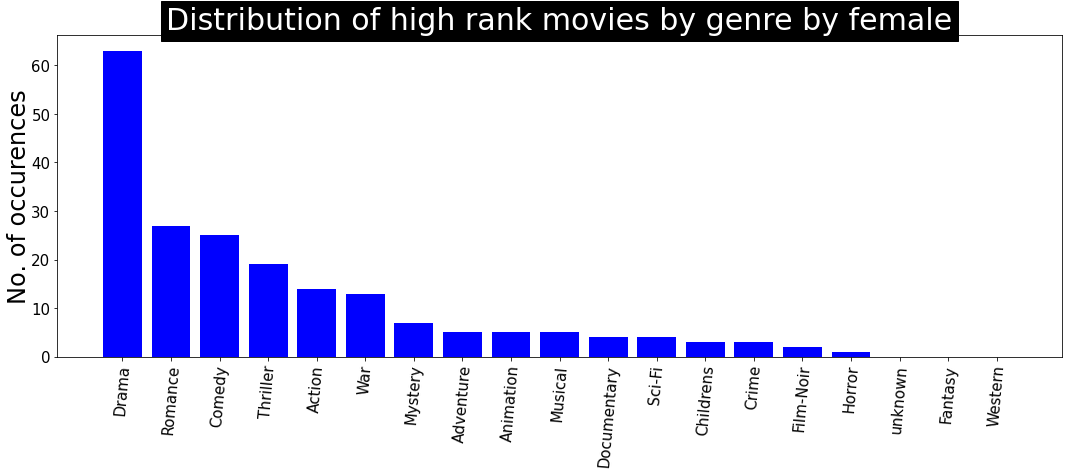

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of high rank movies by genre by female",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
lowR=female_movie_data_ratings_data['rating']<2
female_low_rating=lowR=female_movie_data_ratings_data[lowR]
genres_count = {}
for genre in genres:
    count = 0
    genre_movies = female_low_rating[genre] == 1
    genres_count[genre] = female_low_rating[genre_movies].shape[0]
print(genres_count)

{'unknown': 0, 'Action': 16, 'Adventure': 4, 'Animation': 1, 'Childrens': 7, 'Comedy': 32, 'Crime': 7, 'Documentary': 3, 'Drama': 47, 'Fantasy': 3, 'Film-Noir': 0, 'Horror': 20, 'Musical': 2, 'Mystery': 2, 'Romance': 14, 'Sci-Fi': 3, 'Thriller': 12, 'War': 5, 'Western': 3}


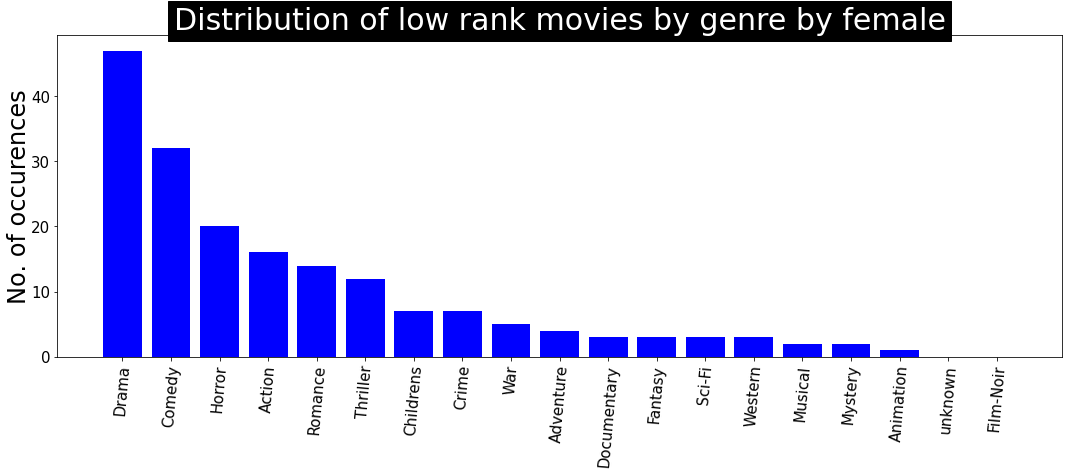

In [ ]:
genres_count_list = sorted(genres_count.items(), key=operator.itemgetter(1),reverse=True)
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [genre[1] for genre in genres_count_list]
x_axis = [i for i in range(len(genres_count))]
x_label = [genre[0] for genre in genres_count_list]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='b')
plt.title("Distribution of low rank movies by genre by female",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

### 1.d Finding the most popular movies

In [ ]:
user_rating.head()
user_rating['freq']=user_rating.groupby('movie_id')['movie_id'].transform('count')
user_rating.sort_values(by='freq', ascending=False)
popular=user_rating.sort_values(by='freq',ascending=False)
aggregation_functions = { 'freq': 'first'}
popular_movies=popular.groupby(popular['movie_id']).aggregate(aggregation_functions)
p=popular_movies.sort_values(by='freq',ascending=False)
p


,freq
movie_id,
50,484
181,422
258,402
100,395
294,394
...,...
1564,1
1566,1
1567,1


In [ ]:
movie_data_ratings_data.head()
popular_movies_all=p.merge(movie_data_ratings_data,how='inner',on='movie_id')
popular_movies_all.drop(['unknown','release date','video release date','IMDb URL','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western'], axis=1, inplace=True)
popular_movies_all.head()

,movie_id,freq,movie title,rating
0,50,484,Star Wars (1977),4.4
1,181,422,Return of the Jedi (1983),4.0
2,258,402,Contact (1997),3.8
3,100,395,Fargo (1996),4.1
4,294,394,Liar Liar (1997),3.2


In [ ]:
popular_movies_all['freq'] = popular_movies_all['freq'].div(484)
popular_movies_all['rating'] = popular_movies_all['rating'].div(5)
popular_movies_all['freqAlpha'] = popular_movies_all['freq'].multiply(0.5)
popular_movies_all['ratingAlpha'] = popular_movies_all['rating'].multiply(0.5)
popular_movies_all['totalPopularityRank']=popular_movies_all['ratingAlpha']+popular_movies_all['freqAlpha'].round(2)
mostPopular=popular_movies_all.sort_values(by='totalPopularityRank',ascending=False)
mostPopular

,movie_id,freq,movie title,rating,freqAlpha,ratingAlpha,totalPopularityRank
0,50,1.000000,Star Wars (1977),0.88,0.500000,0.44,0.94
1,181,0.871901,Return of the Jedi (1983),0.80,0.435950,0.40,0.84
3,100,0.816116,Fargo (1996),0.82,0.408058,0.41,0.82
2,258,0.830579,Contact (1997),0.76,0.415289,0.38,0.80
7,1,0.791322,Toy Story (1995),0.78,0.395661,0.39,0.79
...,...,...,...,...,...,...,...
1612,1574,0.002066,Pharaoh's Army (1995),0.20,0.001033,0.10,0.10
1573,1354,0.002066,Venice/Venice (1992),0.20,0.001033,0.10,0.10
1614,1576,0.002066,"Hungarian Fairy Tale, A (1987)",0.20,0.001033,0.10,0.10
1615,1577,0.002066,"Death in the Garden (Mort en ce jardin, La) (1...",0.20,0.001033,0.10,0.10


# **Question 2**

### Loading data

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
RATING_DATA_FILE = MOVIELENS_DIR+'u.item'

In [ ]:
m_cols = ['movie_id','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data= pd.read_csv(RATING_DATA_FILE,delimiter='|',names=m_cols,encoding='latin-1')
data.shape

(1682, 24)

In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
user_rating = pd.read_csv(MOVIELENS_DIR + 'u1.base',delimiter='\t', names=r_cols) #train data
user_rating.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
average_movie_ratings = user_rating.groupby('movie_id')[['rating']].mean().round(1)
average_movie_ratings.head()

,rating
movie_id,
1,3.9
2,3.2
3,3.0
4,3.5
5,3.3


In [ ]:
movie_data_ratings_data=data.merge(average_movie_ratings,on = 'movie_id',how = 'inner')
movie_data_ratings_data.head(3)

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.9
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.2
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0


In [ ]:
user_rating = pd.read_csv(MOVIELENS_DIR + 'u.data',delimiter='\t', names=r_cols)
average_movie_ratings = user_rating.groupby('movie_id')[['movie_id', 'rating']].mean().round(1)
x = average_movie_ratings['movie_id']==100
average_movie_ratings[x].head()

,movie_id,rating
movie_id,,
100,100.0,4.2


In [ ]:
user_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])
men_user_data = user_data[user_data['gender'] == 'M']
men_user_rating = user_rating.merge(men_user_data['user_id'],on = 'user_id',how = 'inner')
men_average_movie_ratings = men_user_rating.groupby('movie_id')[['rating']].mean().round(1)

women_user_data = user_data[user_data['gender'] == 'F']
women_user_rating = user_rating.merge(women_user_data['user_id'],on = 'user_id',how = 'inner')
women_average_movie_ratings = women_user_rating.groupby('movie_id')[['rating']].mean().round(1)


### 2.1 - calculate MAE for a model of movie rating based on aberage movie rating

In [ ]:
# EX2.1 - calculate MAE for a model of movie rating based on average movie rating
test = pd.read_csv(MOVIELENS_DIR + 'u1.test',delimiter='\t', names=r_cols)
average_movie_ratings = user_rating.groupby('movie_id')[['rating']].mean().round(1)
test_average_movie_ratings = test.merge(average_movie_ratings,on = 'movie_id',how = 'inner',suffixes=('_test', '_average'))
test_average_movie_ratings['abs_diff'] = abs(test_average_movie_ratings.rating_test - test_average_movie_ratings.rating_average)
rows_num = test_average_movie_ratings.shape[0]
sum_diffs = test_average_movie_ratings['abs_diff'].sum()
MAE = sum_diffs / rows_num
print("The MAE of the test data by an average rating model is " + str(MAE))

The MAE of the test data by an average rating model is 0.807005


### 2.3 - calculate MAE for MEN for a model of movie rating based on average movie rating

In [ ]:
# EX 2.3 - calculate MAE for MEN for a model of movie rating based on average movie rating
test = pd.read_csv(MOVIELENS_DIR + 'u1.test',delimiter='\t', names=r_cols)

#filter the MEN to the test
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])
users = test[['user_id']].drop_duplicates() 
men_users = users.merge(users_data, on='user_id', how='inner')
men_users = men_users[men_users['gender']=='M']
men_users = men_users[['user_id']] #all the men users

test_men = test.merge(men_users, on='user_id', how='inner') #test data of men users

average_movie_ratings = user_rating.groupby('movie_id')[['rating']].mean().round(1)
test_average_movie_ratings = test_men.merge(men_average_movie_ratings,on = 'movie_id',how = 'inner',suffixes=('_test', '_average'))
test_average_movie_ratings['abs_diff'] = abs(test_average_movie_ratings.rating_test - test_average_movie_ratings.rating_average)
rows_num = test_average_movie_ratings.shape[0]
sum_diffs = test_average_movie_ratings['abs_diff'].sum()
MAE = sum_diffs / rows_num
print("The MAE of the men users test data by an average rating model is " + str(MAE))

The MAE of the men users test data by an average rating model is 0.780398233005868


### 2.3 - calculate MAE for WOMEN for a model of movie rating based on average movie rating

In [ ]:
# EX 2.3 - calculate MAE for WOMEN for a model of movie rating based on average movie rating
test = pd.read_csv(MOVIELENS_DIR + 'u1.test',delimiter='\t', names=r_cols)

#filter the WOMEN to the test
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])
users = test[['user_id']].drop_duplicates() 
women_users = users.merge(users_data, on='user_id', how='inner')
women_users = women_users[women_users['gender']=='F']
women_users = women_users[['user_id']] #all the women users

test_women = test.merge(women_users, on='user_id', how='inner') #test data of women users

average_movie_ratings = user_rating.groupby('movie_id')[['rating']].mean().round(1)
test_average_movie_ratings = test_women.merge(women_average_movie_ratings,on = 'movie_id',how = 'inner',suffixes=('_test', '_average'))
test_average_movie_ratings['abs_diff'] = abs(test_average_movie_ratings.rating_test - test_average_movie_ratings.rating_average)
rows_num = test_average_movie_ratings.shape[0]
sum_diffs = test_average_movie_ratings['abs_diff'].sum()
MAE = sum_diffs / rows_num
print("The MAE of the women users test data by an average rating model is " + str(MAE))

The MAE of the women users test data by an average rating model is 0.852658804055452


### 2.2 - calculate Precision and Recall when recommending 20 best rating movies to users

In [ ]:
# EX 2.2 - calculate Precision and Recall when recommending 20 best rating movies to users

best_20_movies = average_movie_ratings.nlargest(20, 'rating')

test_best_20_movies = test.merge(best_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_best_20_movies_relevant = test_best_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

users = test[['user_id']].drop_duplicates() #all the users. we need them because maybe some got recommendations that they did not watch any of them

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = users.merge(test_best_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For all the test users based on a recommendation of the best 20 movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))


For all the test users based on a recommendation of the best 20 movies: 
The average precision is: 0.023093681917211326
The average recall is: 0.009058944549662416


### 2.2 - calculate Precision and Recall when recommending 20 random rating movies to users

In [ ]:
# EX 2.2 - calculate Precision and Recall when recommending 20 random rating movies to users

random_20_movies = average_movie_ratings.sample(20)

test_random_20_movies = test.merge(random_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_random_20_movies_relevant = test_random_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

users = test[['user_id']].drop_duplicates() #all the users. we need them because maybe some got recommendations that they did not watch any of them

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = users.merge(test_random_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For all the test users based on a recommendation of 20 random movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))

For all the test users based on a recommendation of 20 random movies: 
The average precision is: 0.0142701525054466
The average recall is: 0.005127985091906729


### 2.3 - calculate Precision and Recall when recommending 20 best rating movies to MEN users

In [ ]:
#EX 2.3 - calculate Precision and Recall when recommending 20 best rating movies to MEN users

best_20_movies = men_average_movie_ratings.nlargest(20, 'rating') # best 20 movies based on men rating

test_best_20_movies = test.merge(best_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_best_20_movies_relevant = test_best_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

# filter only men users
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])

users = test[['user_id']].drop_duplicates() #all the men users. we need them because maybe some got recommendations that they did not watch any of them
men_users = users.merge(users_data, on='user_id', how='inner')
men_users = men_users[men_users['gender']=='M']
men_users = men_users[['user_id']]

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = men_users.merge(test_best_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For men test users based on a recommendation of the best 20 movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))


For men test users based on a recommendation of the best 20 movies: 
The average precision is: 0.003963414634146343
The average recall is: 0.001724115819699719


### 2.3 - calculate Precision and Recall when recommending 20 random rating movies to MEN users

In [ ]:
#EX 2.3 - calculate Precision and Recall when recommending 20 random rating movies to MEN users

random_20_movies = men_average_movie_ratings.sample(20) # random 20 movies based on men rating

test_random_20_movies = test.merge(random_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_random_20_movies_relevant = test_random_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

# filter only men users
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])

users = test[['user_id']].drop_duplicates() #all the men users. we need them because maybe some got recommendations that they did not watch any of them
men_users = users.merge(users_data, on='user_id', how='inner')
men_users = men_users[men_users['gender']=='M']
men_users = men_users[['user_id']]

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = men_users.merge(test_random_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For men test users based on a recommendation of 20 random movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))

For men test users based on a recommendation of 20 random movies: 
The average precision is: 0.026981707317073163
The average recall is: 0.01385697912129671


### 2.3 - calculate Precision and Recall when recommending 20 best rating movies to WOMEN users

In [ ]:
#EX 2.3 - calculate Precision and Recall when recommending 20 best rating movies to WOMEN users

best_20_movies = women_average_movie_ratings.nlargest(20, 'rating')

test_best_20_movies = test.merge(best_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_best_20_movies_relevant = test_best_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

# filter only women users
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])

users = test[['user_id']].drop_duplicates() #all the women users. we need them because maybe some got recommendations that they did not watch any of them
women_users = users.merge(users_data, on='user_id', how='inner')
women_users = women_users[women_users['gender']=='F']
women_users = women_users[['user_id']]

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = women_users.merge(test_best_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For women test users based on a recommendation of the best 20 movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))

For women test users based on a recommendation of the best 20 movies: 
The average precision is: 0.022137404580152672
The average recall is: 0.009669421340745285


### 2.3 - calculate Precision and Recall when recommending 20 random rating movies to WOMEN users

In [ ]:
#EX 2.3 - calculate Precision and Recall when recommending 20 random rating movies to WOMEN users

random_20_movies = women_average_movie_ratings.sample(20)

test_random_20_movies = test.merge(random_20_movies, on="movie_id", how='inner') #represents the relevant movies that were retrieved for each user
test_random_20_movies_relevant = test_random_20_movies.groupby('user_id')['user_id'].count().reset_index(name="retrieved_relevant_count") #represents the amount of movies that were recommended to the user and were relevant (the user watched them)
test_number_of_relevant_documents = test.groupby('user_id')['user_id'].count().reset_index(name="relevant_documents_count") #represents the amount of relevant (that the user watched) movies per user

# filter only men users
users_data = pd.read_csv(MOVIELENS_DIR + 'u.user',delimiter='|', names=['user_id','age','gender','occupation','zip code'])

users = test[['user_id']].drop_duplicates() #all the women users. we need them because maybe some got recommendations that they did not watch any of them
women_users = users.merge(users_data, on='user_id', how='inner')
women_users = women_users[women_users['gender']=='F']
women_users = women_users[['user_id']]

# merge the recommended movies number and the relevant movies number
test_precision_recall_per_user = women_users.merge(test_random_20_movies_relevant, on='user_id', how='left')
test_precision_recall_per_user = test_precision_recall_per_user.merge(test_number_of_relevant_documents, on='user_id', how='inner')

# calculate the precision and recall per user
test_precision_recall_per_user['precision'] = test_precision_recall_per_user.retrieved_relevant_count / 20
test_precision_recall_per_user['recall'] = test_precision_recall_per_user.retrieved_relevant_count / test_precision_recall_per_user.relevant_documents_count
test_precision_recall_per_user = test_precision_recall_per_user.fillna(0)

#calculate the average precision and recall
avg_precision = test_precision_recall_per_user['precision'].mean()
avg_recall = test_precision_recall_per_user['recall'].mean()

print("For women test users based on a recommendation of 20 random movies: ")
print("The average precision is: " + str(avg_precision))
print("The average recall is: " + str(avg_recall))

For women test users based on a recommendation of 20 random movies: 
The average precision is: 0.016030534351145043
The average recall is: 0.006533949842318579


# **Question 3**

### Loading data

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
MOVIES_DATA_FILE = MOVIELENS_DIR + 'u.item'
USERS_DATA_FILE = MOVIELENS_DIR + 'u.user'
RATING_DATA_FILE = MOVIELENS_DIR + 'u1.base'

In [ ]:
movies_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
movies_data = pd.read_csv(MOVIES_DATA_FILE,delimiter='|',names=movies_cols,encoding='latin-1')
movies_data.head()

,movie_id,movie_title,release_date,video_release date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_data = pd.read_csv(USERS_DATA_FILE,delimiter='|',names=user_cols, encoding='latin-1')
users_data.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
rating_data = pd.read_csv(RATING_DATA_FILE, delimiter='\t', names=rating_cols, encoding='latin-1')
rating_data.shape

(80000, 4)

### Getting data ready for turicreate

In [ ]:
rating_sf = turicreate.SFrame(rating_data.replace({np.nan: None})).remove_columns(['timestamp'])
user_sf = turicreate.SFrame(users_data.replace({np.nan: None})).remove_columns(['zip_code', 'occupation'])
movie_sf = turicreate.SFrame(movies_data.replace({np.nan: None}))
movie_sf = movie_sf.remove_columns(['movie_title', 'release_date', 'video_release_date', 'IMDb_URL'])
movie_sf.head()

movie_id,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir
1,0,0,0,1,1,1,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,1,0,1,0,0
6,0,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,1,0,0,1,0,0
9,0,0,0,0,0,0,0,0,1,0,0
10,0,0,0,0,0,0,0,0,1,0,0


### Creating the models

Matrix factorization recommender

In [ ]:
matrix_factorization_model = turicreate.factorization_recommender.create(rating_sf, 'user_id', 'movie_id', target='rating', user_data=user_sf, item_data=movie_sf)

Preparing data set.

Data has 80000 observations with 943 users and 1682 items.

Data prepared in: 0.078452s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.17391           | Not Viable                               |

| 1       | 0.543478          | Not Viable                               |

| 2       | 0.13587           | 0.522846                                 |

| 3       | 0.0679348         | 0.673836                                 |

| 4       | 0.0339674         | 0.84296                                  |

| 5       | 0.0169837         | 1.00345                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.13587           | 0.522846                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 85us         | 1.25114           | 1.11854               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 153.512ms    | 1.18275           | 1.08754               | 0.13587     |

| 2       | 303.543ms    | 1.01003           | 1.005                 | 0.13587     |

| 3       | 460.279ms    | 0.90712           | 0.952423              | 0.13587     |

| 4       | 605.754ms    | 0.86782           | 0.931563              | 0.13587     |

| 5       | 756.138ms    | 0.84073           | 0.916907              | 0.13587     |

| 10      | 1.48s        | 0.796693          | 0.89257               | 0.13587     |

| 25      | 3.56s        | 0.75775           | 0.87048               | 0.13587     |

| 50      | 7.02s        | 0.730282          | 0.854556              | 0.13587     |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.711741

Final training RMSE: 0.843638

Item similarity recommender

In [ ]:
item_similarity_model = turicreate.item_similarity_recommender.create(rating_sf, 'user_id', 'movie_id', target='rating', item_data=movie_sf, similarity_type='pearson')

Preparing data set.

Data has 80000 observations with 943 users and 1682 items.

Data prepared in: 0.076814s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.055ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.861ms                             | 0                | 2               |

| 310.042ms                           | 100              | 1682            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.324781s

Item content recommender

In [ ]:
item_content_model = turicreate.item_content_recommender.create(movie_sf, item_id='movie_id', observation_data=rating_sf, user_id='user_id', target='rating', weights='auto', max_item_neighborhood_size=movie_sf.shape[0])

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Excluded Features : ['movie_id']

Column       Type  Interpretation  Transforms   Output Type
-----------  ----  --------------  -----------  -----------
unknown      int   categorical     astype(str)  str        
Action       int   categorical     astype(str)  str        
Adventure    int   categorical     astype(str)  str        
Animation    int   categorical     astype(str)  str        
Childrens    int   categorical     astype(str)  str        
Comedy       int   categorical     astype(str)  str        
Crime        int   categorical     astype(str)  str        
Documentary  int   categorical     astype(str)  str        
Drama        int   categorical     astype(str)  str  

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 1682    | 0.059453    | 6.137ms      |

| Done         |         | 100         | 548.709ms    |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 80000 observations with 943 users and 1682 items.

Data prepared in: 1.70716s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.152096s

### MAE of each model

In [ ]:
TEST_RATING_DATA_FILE = MOVIELENS_DIR + 'u1.test'
test = turicreate.SFrame(pd.read_csv(TEST_RATING_DATA_FILE, delimiter='\t', names=rating_cols, encoding='latin-1'))

Matrix factorization

In [ ]:
mean_absolute_error(test['rating'], matrix_factorization_model.predict(test))

0.7508269812417951

Item similarity

In [ ]:
mean_absolute_error(test['rating'], item_similarity_model.predict(test))

0.8257963406743358

Item content

In [ ]:
mean_absolute_error(test['rating'], item_content_model.predict(test))

1.0243307893501554

In [ ]:
user_sf.head()

user_id,age,gender
1,24,M
2,53,F
3,23,M
4,24,M
5,33,F
6,42,M
7,57,M
8,36,M
9,29,M
10,53,M


# **Question 4**

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
RATING_DATA_FILE = MOVIELENS_DIR+'u1.base'

### Preparing the data

In [ ]:
ratings = pd.read_csv(RATING_DATA_FILE, 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(str(len(ratings))+' ratings loaded')

80000 ratings loaded


In [ ]:
Users = ratings['user_emb_id'].values
Movies = ratings['movie_emb_id'].values
Ratings = ratings['rating'].values

### Building the NCF model

In [ ]:
'''this function built a ncf model according to the input and prints the summery of it
num_users- number of users
num_items - number of items
latent_dim - numbers of layers
hidden_dim - size of layers
do - dropout
'''
def ncf_model(num_users, num_items, latent_dim,hidden_dim,do):
  # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # flatting the embedding vectors
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

  # Element-wise product of user and item embeddings
    c = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(c)
    hid1 = Dense(hidden_dim, activation='relu')(c)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input], output=prediction)
    print("ncf model")
    model.summary()

    return model

In [ ]:
K_LATENT = 1
hidden_dim = 20
do = 0.5

In [ ]:
NCF_model = ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(lr=0.001),metrics=['mae'])

ncf model
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 1)         943         user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 1)         1682        item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
MODEL_WEIGHTS_FILE = 'u_emb_weights.h5'
MODEL_WEIGHTS_FILE_CORE = 'u_emb_weights'
callbacks_ncf = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE_CORE+'_ncf_'+str(do)+'_'+str(K_LATENT)+'_'+str(hidden_dim)+'.h5', save_best_only=True)]
history_history_ncf = NCF_model.fit([Users, Movies], Ratings, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncf, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 41us/step - loss: 3.9384 - mae: 1.6057 - val_loss: 1.2596 - val_mae: 0.9403
Epoch 2/100
72000/72000 [==============================] - 3s 38us/step - loss: 1.7842 - mae: 1.0851 - val_loss: 1.1836 - val_mae: 0.9090
Epoch 3/100
72000/72000 [==============================] - 3s 37us/step - loss: 1.3813 - mae: 0.9543 - val_loss: 1.1003 - val_mae: 0.8704
Epoch 4/100
72000/72000 [==============================] - 3s 37us/step - loss: 1.1610 - mae: 0.8701 - val_loss: 1.0434 - val_mae: 0.8384
Epoch 5/100
72000/72000 [==============================] - 3s 37us/step - loss: 1.0439 - mae: 0.8204 - val_loss: 1.0209 - val_mae: 0.8261
Epoch 6/100
72000/72000 [==============================] - 3s 37us/step - loss: 0.9886 - mae: 0.7965 - val_loss: 1.0054 - val_mae: 0.8161
Epoch 7/100
72000/72000 [==============================] - 3s 38us/step - loss: 0.9611 - mae: 0.7823 - val_loss: 0.9982 - v

### Finding the MAE for the testing set

In [ ]:
TEST_RATING_DATA_FILE = MOVIELENS_DIR + 'u1.test'
test = pd.read_csv(TEST_RATING_DATA_FILE, 
                     delimiter='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid__test = test['userid'].drop_duplicates().max()
max_movieid_test = test['movieid'].drop_duplicates().max()
test['user_emb_id'] = test['userid'] - 1
test['movie_emb_id'] = test['movieid'] - 1
print(str(len(test))+' testing loaded')
Users_test = test['user_emb_id'].values
Movies_test = test['movie_emb_id'].values
Ratings_test = test['rating'].values

20000 testing loaded


In [ ]:
pred=NCF_model.predict([Users_test,Movies_test])
# pred.size
mean_absolute_error(test['rating'], pred).round(3)

0.758

### Different amount of hidden layers

In [ ]:
K_LATENT_2 = 20
hidden_dim_2 =20
do_2 = 0.5
NCF_model_2 = ncf_model(max_userid,max_movieid,K_LATENT_2,hidden_dim_2,do_2)
NCF_model_2.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

ncf model
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
NCF_model_2 = ncf_model(max_userid,max_movieid,K_LATENT_2,hidden_dim_2,do_2)
NCF_model_2.compile(loss='mse',optimizer=Adamax(lr=0.001),metrics=['mae'])

ncf model
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        18860       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 20)        33640       item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:

callbacks_ncf_2 = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE_CORE+'_ncf_'+str(do_2)+'_'+str(K_LATENT_2)+'_'+str(hidden_dim_2)+'.h5', save_best_only=True)]
history_history_ncf_2 = NCF_model_2.fit([Users, Movies], Ratings, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncf_2, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 48us/step - loss: 3.0821 - mae: 1.3863 - val_loss: 1.2330 - val_mae: 0.9177
Epoch 2/100
72000/72000 [==============================] - 3s 48us/step - loss: 1.4537 - mae: 0.9687 - val_loss: 1.1929 - val_mae: 0.9026
Epoch 3/100
72000/72000 [==============================] - 3s 47us/step - loss: 1.2280 - mae: 0.8903 - val_loss: 1.1083 - val_mae: 0.8642
Epoch 4/100
72000/72000 [==============================] - 3s 46us/step - loss: 1.1011 - mae: 0.8415 - val_loss: 1.0904 - val_mae: 0.8566
Epoch 5/100
72000/72000 [==============================] - 3s 48us/step - loss: 1.0109 - mae: 0.8054 - val_loss: 1.0753 - val_mae: 0.8503
Epoch 6/100
72000/72000 [==============================] - 3s 49us/step - loss: 0.9675 - mae: 0.7876 - val_loss: 1.0737 - val_mae: 0.8508
Epoch 7/100
72000/72000 [==============================] - 3s 46us/step - loss: 0.9365 - mae: 0.7733 - val_loss: 1.0497 - v

In [ ]:
pred_2=NCF_model_2.predict([Users_test,Movies_test])
# pred.size
mean_absolute_error(test['rating'], pred_2).round(3)

0.748

### Different size of each layer

In [ ]:
K_LATENT_3 = 1
hidden_dim_3 =50
do_2 = 0.5
NCF_model_3 = ncf_model(max_userid,max_movieid,K_LATENT_3,hidden_dim_3,do_2)
NCF_model_3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

ncf model
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 1)         943         user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 1)         1682        item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
NCF_model_3 = ncf_model(max_userid,max_movieid,K_LATENT_3,hidden_dim_3,do_2)
NCF_model_3.compile(loss='mse',optimizer=Adamax(lr=0.001),metrics=['mae'])

ncf model
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 1)         943         user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 1)         1682        item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:

callbacks_ncf_3 = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE_CORE+'_ncf_'+str(do_2)+'_'+str(K_LATENT_3)+'_'+str(hidden_dim_3)+'.h5', save_best_only=True)]
history_history_ncf_3 = NCF_model_3.fit([Users, Movies], Ratings, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncf_3, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 43us/step - loss: 2.7906 - mae: 1.3115 - val_loss: 1.1732 - val_mae: 0.9083
Epoch 2/100
72000/72000 [==============================] - 3s 42us/step - loss: 1.4301 - mae: 0.9659 - val_loss: 1.1199 - val_mae: 0.8712
Epoch 3/100
72000/72000 [==============================] - 3s 42us/step - loss: 1.2521 - mae: 0.9008 - val_loss: 1.0988 - val_mae: 0.8568
Epoch 4/100
72000/72000 [==============================] - 3s 42us/step - loss: 1.1467 - mae: 0.8590 - val_loss: 1.0666 - val_mae: 0.8393
Epoch 5/100
72000/72000 [==============================] - 3s 43us/step - loss: 1.0706 - mae: 0.8283 - val_loss: 1.0615 - val_mae: 0.8351
Epoch 6/100
72000/72000 [==============================] - 3s 44us/step - loss: 1.0113 - mae: 0.8039 - val_loss: 1.0589 - val_mae: 0.8350
Epoch 7/100
72000/72000 [==============================] - 3s 43us/step - loss: 0.9749 - mae: 0.7879 - val_loss: 1.0529 - v

In [ ]:
pred_3=NCF_model_3.predict([Users_test,Movies_test])
# pred.size
mean_absolute_error(test['rating'], pred_3).round(3)


0.752

### Different activation function

In [ ]:
'''this function built a ncf model according to the input and prints the summery of it
num_users- number of users
num_items - number of items
latent_dim - numbers of layers
hidden_dim - size of layers
do - dropout
'''
def ncf_model_4(num_users, num_items, latent_dim,hidden_dim,do):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    c = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(c)
    hid1 = Dense(hidden_dim, activation='softplus')(c)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='softplus', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input], output=prediction)
    print("ncf model")
    model.summary()

    return model

In [ ]:
K_LATENT = 1
hidden_dim = 20
do = 0.5
NCF_model = ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

ncf model
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 1)         943         user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 1)         1682        item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
NCF_model = ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(lr=0.001),metrics=['mae'])

ncf model
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 1)         943         user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 1)         1682        item_input[0][0]                 
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
MODEL_WEIGHTS_FILE = 'u_emb_weights.h5'
MODEL_WEIGHTS_FILE_CORE = 'u_emb_weights'
callbacks_ncf = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE_CORE+'_ncf_'+str(do)+'_'+str(K_LATENT)+'_'+str(hidden_dim)+'.h5', save_best_only=True)]
history_history_ncf = NCF_model.fit([Users, Movies], Ratings, nb_epoch=100, validation_split=.1, verbose=1, callbacks=callbacks_ncf, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 44us/step - loss: 2.1493 - mae: 1.1863 - val_loss: 1.1854 - val_mae: 0.9242
Epoch 2/100
72000/72000 [==============================] - 3s 40us/step - loss: 1.6144 - mae: 1.0348 - val_loss: 1.1790 - val_mae: 0.9218
Epoch 3/100
72000/72000 [==============================] - 3s 40us/step - loss: 1.4896 - mae: 0.9928 - val_loss: 1.1615 - val_mae: 0.9136
Epoch 4/100
72000/72000 [==============================] - 3s 41us/step - loss: 1.3619 - mae: 0.9507 - val_loss: 1.1330 - val_mae: 0.8995
Epoch 5/100
72000/72000 [==============================] - 3s 43us/step - loss: 1.2540 - mae: 0.9073 - val_loss: 1.1029 - val_mae: 0.8818
Epoch 6/100
72000/72000 [==============================] - 3s 41us/step - loss: 1.1746 - mae: 0.8752 - val_loss: 1.0737 - val_mae: 0.8624
Epoch 7/100
72000/72000 [==============================] - 3s 42us/step - loss: 1.1204 - mae: 0.8524 - val_loss: 1.0594 - v

In [ ]:
pred=NCF_model.predict([Users_test,Movies_test])
# pred.size
mean_absolute_error(test['rating'], pred).round(3)

0.782

# Question 5

### deepCTR

loading data

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
RATING_DATA_FILE = MOVIELENS_DIR+'u.item'

In [ ]:
m_cols = ['movie_id','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data= pd.read_csv(RATING_DATA_FILE,delimiter='|',names=m_cols,encoding='latin-1')
data.shape

(1682, 24)

In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
#Get user ratings of the training set
user_rating = pd.read_csv(MOVIELENS_DIR + 'u1.base',delimiter='\t', names=r_cols)
user_rating.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


### Prediction by DeepFM Model using DeepCTR package

In [ ]:
#DeepCTR model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import DeepFM
from deepctr.inputs import SparseFeat,get_feature_names



#get all users rating data
r_cols = ['user_id','movie_id','rating','timestamp']
all_data = pd.read_csv(MOVIELENS_DIR + 'u.data',delimiter='\t', names=r_cols)
#get users data
u_cols = ['user_id','age','gender','occupation','zip_code']
data_u = pd.read_csv(MOVIELENS_DIR+'/u.user',delimiter='|',names=u_cols,encoding='latin-1')
#get movies data
m_cols = ['movie_id','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data_m= pd.read_csv(RATING_DATA_FILE,delimiter='|',names=m_cols,encoding='latin-1')

#merge all data and users data and movies data
data = all_data.merge(data_u, on="user_id", how="inner")
data = data.merge(data_m, on="movie_id", how="inner")

#get the train and test data
train_data = pd.read_csv(MOVIELENS_DIR + 'u1.base',delimiter='\t', names=r_cols)
test_data = pd.read_csv(MOVIELENS_DIR + 'u1.test',delimiter='\t', names=r_cols)

# merge the user information data to the train and test data
train = train_data.merge(data_u, on="user_id", how="inner")
test = test_data.merge(data_u, on="user_id", how="inner")

train = train.merge(data_m, on="movie_id", how="inner")
test = test.merge(data_m, on="movie_id", how="inner")


#discretize the age of the users
train.head()
bins = [0,16,32,48,64]
labels = ["kid", "young", "middle-aged", "older"]
train["binned_age"] = pd.cut(train["age"], bins=bins, labels=labels)
test["binned_age"] = pd.cut(test["age"], bins=bins, labels=labels)
data["binned_age"] = pd.cut(data["age"], bins=bins, labels=labels)
#make the binned aged string
train["binned_age"] = train.binned_age.astype(str)
test["binned_age"] = test.binned_age.astype(str)
data["binned_age"] = data.binned_age.astype(str)


#the features we want to predict based on them
sparse_features = ["movie_id", "user_id", "age", "gender"]
target = ['rating']


# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    train[feat] = lbe.fit_transform(train[feat])
    test[feat] = lbe.fit_transform(test[feat])



# 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
# 3.generate input data for model based on u1.base and u1.test files
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}
# 4.Define Model,train,predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',)
model.compile("adam", "mae", metrics=['mae'], )
history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.1, )
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(
    test[target].values, pred_ans), 4))
MAE = mean_absolute_error(test[target], pred_ans)
print("test MAE", MAE)


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


282/282 - 1s - loss: 1.0917 - mae: 1.0917 - val_loss: 0.8660 - val_mae: 0.8659
Epoch 2/10
282/282 - 1s - loss: 0.7315 - mae: 0.7314 - val_loss: 0.8663 - val_mae: 0.8662
Epoch 3/10
282/282 - 1s - loss: 0.7226 - mae: 0.7225 - val_loss: 0.8662 - val_mae: 0.8660
Epoch 4/10
282/282 - 1s - loss: 0.7174 - mae: 0.7172 - val_loss: 0.8774 - val_mae: 0.8772
Epoch 5/10
282/282 - 1s - loss: 0.7131 - mae: 0.7129 - val_loss: 0.8787 - val_mae: 0.8785
Epoch 6/10
282/282 - 1s - loss: 0.7046 - mae: 0.7044 - val_loss: 0.8636 - val_mae: 0.8633
Epoch 7/10
282/282 - 1s - loss: 0.6966 - mae: 0.6963 - val_loss: 0.8644 - val_mae: 0.8641
Epoch 8/10
282/282 - 1s - loss: 0.6888 - mae: 0.6885 - val_loss: 0.8621 - val_mae: 0.8618
Epoch 9/10
282/282 - 1s - loss: 0.6825 - mae: 0.6822 - val_loss: 0.8616 - val_mae: 0.8613
Epoch 10/10
282/282 - 1s - loss: 0.6771 - mae: 0.6767 - val_loss: 0.8667 - val_mae: 0.8663
test MSE 1.1872
test MAE 0.8210683944255114


### Keras

Neural Collaborative Filtering in Keras with age and gender information

In [ ]:
MOVIELENS_DIR = '/content/drive/My Drive/eCommerce Project/ml-100k/'
RATING_DATA_FILE = MOVIELENS_DIR + 'u1.base'
USERS_DATA_FILE = MOVIELENS_DIR + 'u.user'
MOVIES_DATA_FILE = MOVIELENS_DIR + 'u.item'
TEST_FILE = MOVIELENS_DIR + 'u1.test'

In [ ]:
ratings = pd.read_csv(RATING_DATA_FILE, 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_data = pd.read_csv(USERS_DATA_FILE,delimiter='|',names=user_cols, encoding='latin-1')

movies_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
movies_data = pd.read_csv(MOVIES_DATA_FILE,delimiter='|',names=movies_cols,encoding='latin-1')

test = pd.read_csv(TEST_FILE, 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [ ]:
ratings = ratings.merge(users_data[['user_id', 'age', 'gender']], on='user_id', how='inner')
ratings['gender'] = ratings['gender'].replace('M', 1)
ratings['gender'] = ratings['gender'].replace('F', 0)
ratings.head()

,user_id,movie_id,rating,timestamp,age,gender
0,1,1,5,874965758,24,1
1,1,2,3,876893171,24,1
2,1,3,4,878542960,24,1
3,1,4,3,876893119,24,1
4,1,5,3,889751712,24,1


In [ ]:
'''this function built a ncf model according to the input and prints the summery of it
num_users- number of users
num_items - number of items
latent_dim - numbers of layers
hidden_dim - size of layers
do - dropout
this model considers in the user's age and gender
'''
def get_gmf_model_gen(num_users, num_items, latent_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int16', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int16', name = 'item_input')
    age_input = Input(shape=(1,), dtype='float32', name = 'age_input')
    gender_input = Input(shape=(1,), dtype='float32', name = 'gender_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
   
    conc = Concatenate()([user_latent, item_latent, age_input, gender_input])
    hidden = Dense(20, activation='relu')(conc)
    drop = Dropout(do)(hidden)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop)
    
    
    model = Model(input=[user_input, item_input, age_input, gender_input], output=prediction)

    return model

In [ ]:
general_martix_factorization_model = get_gmf_model_gen(users_data.shape[0], movies_data.shape[0], 10, 0)
general_martix_factorization_model.compile(loss='mae', optimizer=Adamax(),metrics=['mae'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [ ]:
Users = ratings['user_id'] - 1
Movies = ratings['movie_id'] - 1

In [ ]:
history = general_martix_factorization_model.fit([Users.values, Movies.values, ratings['age'].values, ratings['gender'].values], ratings['rating'].values, nb_epoch=100, validation_split=.1, verbose=1, batch_size = 32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 8000 samples
Epoch 1/100
72000/72000 [==============================] - 3s 37us/step - loss: 1.1162 - mae: 1.1162 - val_loss: 1.1370 - val_mae: 1.1370
Epoch 2/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7682 - mae: 0.7682 - val_loss: 1.1081 - val_mae: 1.1081
Epoch 3/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7422 - mae: 0.7422 - val_loss: 1.0923 - val_mae: 1.0923
Epoch 4/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7346 - mae: 0.7346 - val_loss: 1.0849 - val_mae: 1.0849
Epoch 5/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7305 - mae: 0.7305 - val_loss: 1.0746 - val_mae: 1.0746
Epoch 6/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7292 - mae: 0.7292 - val_loss: 1.0702 - val_mae: 1.0702
Epoch 7/100
72000/72000 [==============================] - 3s 36us/step - loss: 0.7275 - mae: 0.7275 - val_loss: 1.0662 - v

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
test = test.merge(users_data[['user_id', 'gender', 'age']], on='user_id', how='inner')
test['gender'] = test['gender'].replace('M', 1)
test['gender'] = test['gender'].replace('F', 0)

In [ ]:
mean_absolute_error(test['rating'], general_martix_factorization_model.predict([test['user_id'] - 1,test['movie_id'] - 1, test['age'], test['gender']]))

0.7490211612582207

In [ ]:
test.head()

,user_id,movie_id,rating,timestamp,gender
0,1,6,5,887431973,1
1,1,10,3,875693118,1
2,1,12,5,878542960,1
3,1,14,5,874965706,1
4,1,17,3,875073198,1
